Libs import

In [3]:
import os
import json
import random
import shutil
import pandas as pd
import numpy as np

from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

Global variabels to setup each dataset

In [ ]:
METADATA_CALTECH_PATH = "/data/luiz/dataset/caltech/caltech_images_20210113.json"
DATA_CALTECH_PATH = "/data/luiz/dataset/caltech_images/cct_images/"
DATA_CALTECH_SSD_PATH = "/ssd/luiz/dataset/caltech_images/cct_images/"
CSV_CALTECH_PATH = "/data/luiz/dataset/partitions/animal-classifier/caltech"

Helpers functions

In [13]:
def check_file_exists(file_path):
    return os.path.exists(file_path)

def load_json(json_file_path):
    with open(json_file_path, 'r') as f:
        return json.load(f)

def partition_by_location(df, train_frac=0.7, val_frac=0.15, test_frac=0.15, random_seed=42):
    # Unique locations
    locations = df['location'].unique()
    random.seed(random_seed)
    random.shuffle(locations)
    
    # Determine split sizes
    n = len(locations)
    train_end = int(train_frac * n)
    val_end = train_end + int(val_frac * n)
    
    # Assign locations to partitions
    train_locs = set(locations[:train_end])
    val_locs = set(locations[train_end:val_end])
    test_locs = set(locations[val_end:])
    
    # Filter DataFrames
    train_df = df[df['location'].isin(train_locs)].reset_index(drop=True)
    val_df = df[df['location'].isin(val_locs)].reset_index(drop=True)
    test_df = df[df['location'].isin(test_locs)].reset_index(drop=True)
    
    return train_df, val_df, test_df

def get_caltech_dataset():
    data = load_json(METADATA_CALTECH_PATH)

    # Build image ID to category ID mapping
    image_category_map = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        category_id = ann['category_id']
        image_category_map[image_id] = category_id
    
    # Prepare data for DataFrame
    records = []
    for img in tqdm(data['images']):
        path = img['file_name'].replace('.jpg', '.JPG')
        # Robust timestamp parsing
        date_str = img.get('date_captured', '')
        try:
            timestamp = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S").isoformat()
        except ValueError:
            timestamp = None
        if not check_file_exists(DATA_CALTECH_PATH + path) or timestamp is None:
            continue
        image_id = img['id']
        category = image_category_map.get(image_id, None)
        location = img.get('location', None)
        
        records.append({
            'path': path,
            'category': category,
            'timestamp': timestamp,
            'location': location
        })
    
    # Create DataFrame
    df = pd.DataFrame(records)
    df.category.replace(30, 0, inplace=True)  # Replace category 30 with 0
    return df

def copy_images(df, src_dir, dst_dir):
    """
    Copies images listed in the DataFrame from src_dir to dst_dir.
    
    Parameters:
    - df: pandas DataFrame with 'path' column.
    - src_dir: source directory containing the images.
    - dst_dir: destination directory where images will be copied.
    """
    os.makedirs(dst_dir, exist_ok=True)
    
    for filename in tqdm(df['path'], desc=f"Copying to {dst_dir}"):
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        
        # Ensure destination subdirectory exists if necessary
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        
        try:
            shutil.copy2(src_path, dst_path)  # copy2 preserves metadata
        except FileNotFoundError:
            print(f"Warning: {src_path} not found.")

def save_partitioned_dataframes(train_df, val_df, test_df, base_path, image_path):
    """
    Saves the partitioned DataFrames to CSV files.
    
    Parameters:
    - train_df, val_df, test_df: DataFrames to save.
    - base_path: Base directory where the CSV files will be saved.
    """
    train_df["path"] = train_df["path"].apply(lambda x: os.path.join(image_path, x))
    val_df["path"] = val_df["path"].apply(lambda x: os.path.join(image_path, x))
    test_df["path"] = test_df["path"].apply(lambda x: os.path.join(image_path, x))

    train_df.to_csv(os.path.join(base_path, 'train.csv'), index=False)
    val_df.to_csv(os.path.join(base_path, 'val.csv'), index=False)
    test_df.to_csv(os.path.join(base_path, 'test.csv'), index=False)

def plot_category_distribution_multiple(train_df, val_df, test_df, title="Category Distribution Across Partitions"):
    """
    Plots the category distribution for train, validation, and test DataFrames in a grouped bar chart.
    
    Parameters:
    - train_df, val_df, test_df: DataFrames with 'category' column.
    - title: Title of the plot.
    """
    # Get all unique categories across all partitions
    all_categories = pd.concat([train_df['category'], val_df['category'], test_df['category']]).unique()
    all_categories = sorted(all_categories)
    
    # Count categories in each partition
    train_counts = train_df['category'].value_counts().reindex(all_categories, fill_value=0)
    val_counts = val_df['category'].value_counts().reindex(all_categories, fill_value=0)
    test_counts = test_df['category'].value_counts().reindex(all_categories, fill_value=0)
    
    x = np.arange(len(all_categories))  # Category positions
    width = 0.25  # Bar width

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, train_counts, width, label='Train')
    plt.bar(x, val_counts, width, label='Validation')
    plt.bar(x + width, test_counts, width, label='Test')

    plt.xlabel('Category ID')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(ticks=x, labels=all_categories, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Creating Caltech dataset

In [14]:
df = get_caltech_dataset()

100%|██████████| 243100/243100 [00:06<00:00, 35709.96it/s]
/tmp/ipykernel_20570/2034326072.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.category.replace(30, 0, inplace=True)  # Replace category 30 with 0


In [16]:
train_df, val_df, test_df = partition_by_location(df)

train_df = train_df.sample(10000).reset_index(drop=True)
val_df = val_df.sample(5000).reset_index(drop=True)
test_df = test_df.sample(5000).reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 10000, Val: 5000, Test: 5000


In [59]:
copy_images(pd.concat[train_df, val_df, test_df], src_dir=DATA_CALTECH_PATH, dst_dir=DATA_CALTECH_SSD_PATH)
save_partitioned_dataframes(train_df, val_df, test_df, CSV_CALTECH_PATH, DATA_CALTECH_SSD_PATH)

Copying to /ssd/luiz/dataset/caltech_images/cct_images/: 100%|██████████| 10000/10000 [02:05<00:00, 79.47it/s]
Copying to /ssd/luiz/dataset/caltech_images/cct_images/: 100%|██████████| 5000/5000 [01:12<00:00, 68.57it/s]
Copying to /ssd/luiz/dataset/caltech_images/cct_images/: 100%|██████████| 5000/5000 [01:12<00:00, 68.98it/s]


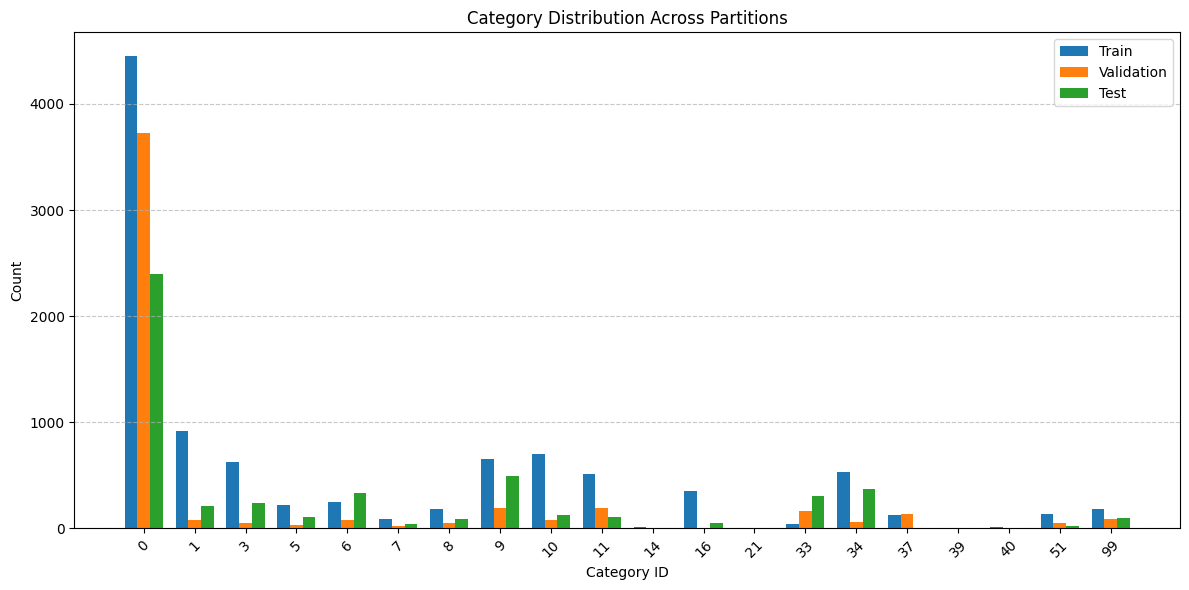

In [18]:
plot_category_distribution_multiple(train_df, val_df, test_df)